In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/Users/pragathi.vetrivelmurugan/Desktop/TSAI/TSAI-Assignment-6/tsai_env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


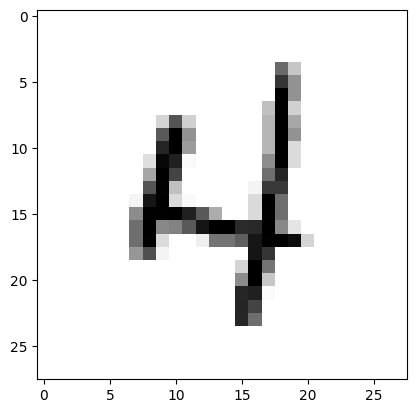

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


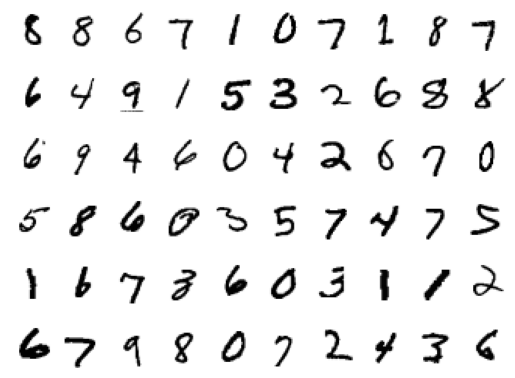

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### Model Definition

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )# 26X26X16 RF - 3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )# 24X24X32 RF - 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(32, 32, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )#10X10X32

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(32, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU() 
        ) # RF - 7
        self.convblock5 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 8 RF - 9
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1 RF - 15
        # self.convblock6 = nn.Sequential(
        #     nn.Conv2d(10, 10, 10, padding=0, bias=False),
        # )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = x.view(-1, 10)  # Flatten the tensor
        return F.log_softmax(x, dim=-1)

#### Model Summary

In [10]:
!pip install torchsummary tqdm
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
         MaxPool2d-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 32, 12, 12]           1,056
       BatchNorm2d-9           [-1, 32, 12, 12]              64
             ReLU-10           [-1, 32, 12, 12]               0
           Conv2d-11           [-1, 32, 10, 10]           9,248
      BatchNorm2d-12           [-1, 32, 10, 10]     

#### Model Training and Testing

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model =  Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
# OneCycleLR settings: steps_per_epoch must match your train_loader
EPOCHS = 15
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=3e-2,
                       steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                       pct_start=0.3, div_factor=20.0, final_div_factor=100, anneal_strategy='cos')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    test(model, device, test_loader)

EPOCH: 0


  0%|                                                   | 0/938 [00:00<?, ?it/s]

Loss=0.2535237967967987 Batch_id=937 Accuracy=89.48: 100%|█| 938/938 [00:40<00:0



Test set: Average loss: 0.3875, Accuracy: 9580/10000 (95.80%)

EPOCH: 1


Loss=0.20677337050437927 Batch_id=937 Accuracy=96.60: 100%|█| 938/938 [00:40<00:



Test set: Average loss: 0.1283, Accuracy: 9773/10000 (97.73%)

EPOCH: 2


Loss=0.06631440669298172 Batch_id=937 Accuracy=97.60: 100%|█| 938/938 [00:40<00:



Test set: Average loss: 0.0883, Accuracy: 9785/10000 (97.85%)

EPOCH: 3


Loss=0.028334863483905792 Batch_id=937 Accuracy=98.02: 100%|█| 938/938 [00:42<00



Test set: Average loss: 0.0617, Accuracy: 9839/10000 (98.39%)

EPOCH: 4


Loss=0.22412708401679993 Batch_id=937 Accuracy=98.23: 100%|█| 938/938 [00:43<00:



Test set: Average loss: 0.0779, Accuracy: 9759/10000 (97.59%)

EPOCH: 5


Loss=0.030738109722733498 Batch_id=937 Accuracy=98.43: 100%|█| 938/938 [00:44<00



Test set: Average loss: 0.0398, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.019193187355995178 Batch_id=937 Accuracy=98.62: 100%|█| 938/938 [00:43<00



Test set: Average loss: 0.0460, Accuracy: 9858/10000 (98.58%)

EPOCH: 7


Loss=0.029831532388925552 Batch_id=937 Accuracy=98.73: 100%|█| 938/938 [00:43<00



Test set: Average loss: 0.0374, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.018760716542601585 Batch_id=937 Accuracy=98.97: 100%|█| 938/938 [00:42<00



Test set: Average loss: 0.0358, Accuracy: 9884/10000 (98.84%)

EPOCH: 9


Loss=0.27646204829216003 Batch_id=937 Accuracy=99.10: 100%|█| 938/938 [00:43<00:



Test set: Average loss: 0.0312, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.006538400426506996 Batch_id=937 Accuracy=99.23: 100%|█| 938/938 [00:43<00



Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.0067934030666947365 Batch_id=937 Accuracy=99.48: 100%|█| 938/938 [00:43<0



Test set: Average loss: 0.0232, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.02056497521698475 Batch_id=937 Accuracy=99.57: 100%|█| 938/938 [00:42<00:



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.008817212656140327 Batch_id=937 Accuracy=99.72: 100%|█| 938/938 [00:43<00



Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.010001949965953827 Batch_id=937 Accuracy=99.76: 100%|█| 938/938 [00:43<00



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

